# Module list

In [48]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import datetime

!pip install torch-summary
from torchsummary import summary

# Sci Learn & Model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

The system cannot find the path specified.


# Conda check

In [49]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


# Inputs & Variables


In [318]:
#Project Name / AutoML_Table_Wrapper
PROJECT_ID = 'Linear_Regression'

#Bucket Name / AutoML_Table_Wrapper
BUCKET_NAME = 'Arnaud_test'

# display the set-up for pandas dataframe
pd.set_option('display.max_columns', None)

# Train name display / AutoML_Table_Wrapper
DATASET_DISPLAY_NAME='Home_Regression'
MODEL_DISPLAY_NAME = 'Test_model'

# Train CSV dataset - length 1460
train_csv = pd.read_csv("train.csv")

# Test CSV dataset - length 1459
test_csv = pd.read_csv("test.csv")

# submission CSV file
submission = pd.read_csv("sample_submission.csv")

# Directory 
data_dir = ""
train_path = data_dir +'train.csv'
test_path = data_dir +'test.csv'

# Target column / AutoML_Table_Wrapper
target_column = 'SalePrice'

# ID column / AutoML_Table_Wrapper
id_column = 'Id'

# Date and Time
date_res = datetime.datetime.now()

# Define Version
#VERSION = 'version_'+date_res.strftime("%m/%d/%Y")+'.pt'
VERSION = 'HR_0203.pt'

# Train Budget / AutoML_Table_Wrapper
TRAIN_BUDGET = 10

# Train set description

In [319]:
dtf_description = train_csv.describe()
train_csv_head = train_csv.head()
#dtf_description

In [320]:
quantitative = [f for f in train_csv.columns if train_csv.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
numeric_features = train_csv.dtypes[train_csv.dtypes != 'object'].index
train_csv[quantitative].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [321]:
qualitative = [f for f in train_csv.columns if train_csv.dtypes[f] == 'object']
object_features = train_csv.dtypes[train_csv.dtypes == 'object'].index
train_csv[object_features].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

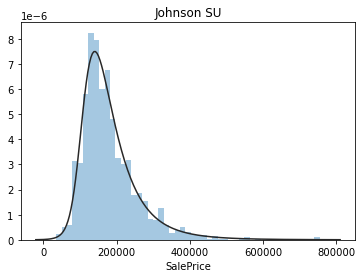

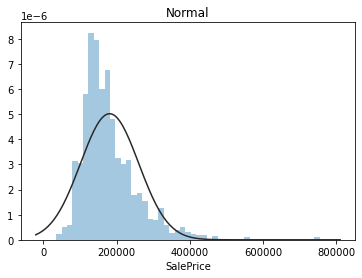

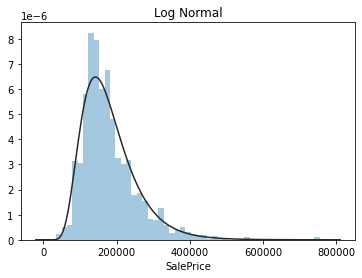

In [322]:
y = train_csv['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

# Test normality

none of quantitative variables has normal distribution so these should be transformed as well.

In [323]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train_csv[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


# Spearman Correlation

Better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations

In [324]:
def encode(frame, feature):
    
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    print(ordering)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_qE'] = o
    
qual_encoded = []
for q in qualitative:  
    print("\nFeatures: {}".format(q))
    encode(train_csv, q)
    qual_encoded.append(q+'_qE')

'''for n in quantitative:
    encode(train_csv, n)
    qual_encoded.append(n+'_E')'''

# Qualitative encoded in the ordering number for each of the value of the Feature. For example: the feature "Street" has two value: Grvl and Pave, the SalesPrice mean for each of these group is calculted and the mean are ordered from the lowest to the highest price  
print(qual_encoded)


Features: MSZoning
             val         spmean  ordering
val                                      
C (all)  C (all)   74528.000000         1
RM            RM  126316.830275         2
RH            RH  131558.375000         3
RL            RL  191004.994787         4
FV            FV  214014.061538         5

Features: Street
       val         spmean  ordering
val                                
Grvl  Grvl  130190.500000         1
Pave  Pave  181130.538514         2

Features: Alley
       val         spmean  ordering
val                                
Grvl  Grvl  122219.080000         1
Pave  Pave  168000.585366         2
NaN    NaN            NaN         3

Features: LotShape
     val         spmean  ordering
val                              
Reg  Reg  164754.818378         1
IR1  IR1  206101.665289         2
IR3  IR3  216036.500000         3
IR2  IR2  239833.365854         4

Features: LandContour
     val         spmean  ordering
val                              
Bnk  Bnk  14


Features: BsmtFinType2
     val         spmean  ordering
val                              
BLQ  BLQ  151101.000000         1
LwQ  LwQ  164364.130435         2
Rec  Rec  164917.129630         3
GLQ  GLQ  180982.142857         4
Unf  Unf  184694.690287         5
ALQ  ALQ  209942.105263         6
NaN  NaN            NaN         7

Features: Heating
         val         spmean  ordering
val                                  
Floor  Floor   72500.000000         1
Grav    Grav   75271.428571         2
Wall    Wall   92100.000000         3
OthW    OthW  125750.000000         4
GasW    GasW  166632.166667         5
GasA    GasA  182021.195378         6

Features: HeatingQC
    val         spmean  ordering
val                             
Po   Po   87000.000000         1
Fa   Fa  123919.489796         2
TA   TA  142362.876168         3
Gd   Gd  156858.871369         4
Ex   Ex  214914.429150         5

Features: CentralAir
    val         spmean  ordering
val                             
N     N

In [325]:
print(qual_encoded)

['MSZoning_qE', 'Street_qE', 'Alley_qE', 'LotShape_qE', 'LandContour_qE', 'Utilities_qE', 'LotConfig_qE', 'LandSlope_qE', 'Neighborhood_qE', 'Condition1_qE', 'Condition2_qE', 'BldgType_qE', 'HouseStyle_qE', 'RoofStyle_qE', 'RoofMatl_qE', 'Exterior1st_qE', 'Exterior2nd_qE', 'MasVnrType_qE', 'ExterQual_qE', 'ExterCond_qE', 'Foundation_qE', 'BsmtQual_qE', 'BsmtCond_qE', 'BsmtExposure_qE', 'BsmtFinType1_qE', 'BsmtFinType2_qE', 'Heating_qE', 'HeatingQC_qE', 'CentralAir_qE', 'Electrical_qE', 'KitchenQual_qE', 'Functional_qE', 'FireplaceQu_qE', 'GarageType_qE', 'GarageFinish_qE', 'GarageQual_qE', 'GarageCond_qE', 'PavedDrive_qE', 'PoolQC_qE', 'Fence_qE', 'MiscFeature_qE', 'SaleType_qE', 'SaleCondition_qE']


In [326]:
print(qualitative)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


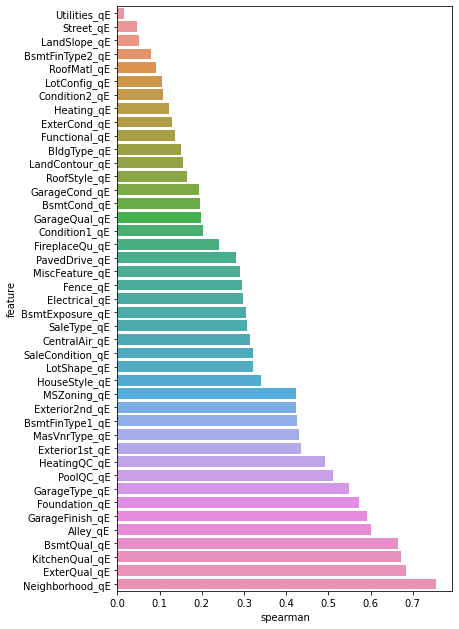

In [327]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qualitative

spearman(train_csv, qual_encoded)

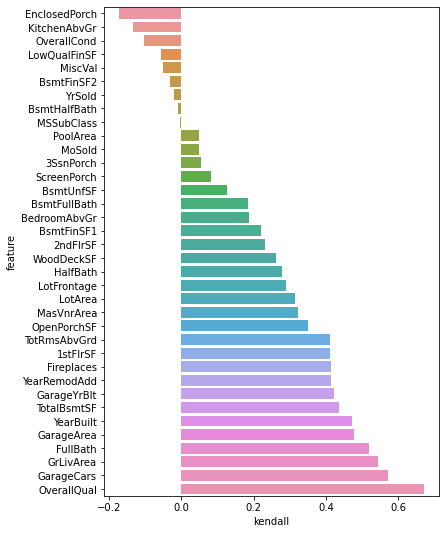

In [328]:
def kendall(frame, features):
    kend = pd.DataFrame()
    kend['feature'] = features
    kend['kendall'] = [frame[f].corr(frame['SalePrice'], 'kendall') for f in features]
    kend = kend.sort_values('kendall')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=kend, y='feature', x='kendall', orient='h')

kendall(train_csv, quantitative)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neig

        Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0        1    0.073350       RL    -0.229293 -0.207071   Pave   NaN      Reg   
1        2   -0.872264       RL     0.451781 -0.091855   Pave   NaN      Reg   
2        3    0.073350       RL    -0.093078  0.073455   Pave   NaN      IR1   
3        4    0.309753       RL    -0.456318 -0.096864   Pave   NaN      IR1   
4        5    0.073350       RL     0.633401  0.375020   Pave   NaN      IR1   
...    ...         ...      ...          ...       ...    ...   ...      ...   
1455  1456    0.073350       RL    -0.365508 -0.260471   Pave   NaN      Reg   
1456  1457   -0.872264       RL     0.678806  0.266316   Pave   NaN      Reg   
1457  1458    0.309753       RL    -0.183888 -0.147760   Pave   NaN      Reg   
1458  1459   -0.872264       RL    -0.093078 -0.080133   Pave   NaN      Reg   
1459  1460   -0.872264       RL     0.224756 -0.058092   Pave   NaN      Reg   

     LandContour Utilities LotConfig La

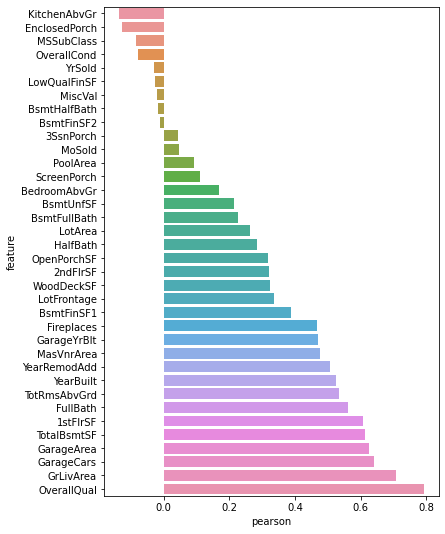

In [329]:
# function to 1. Feel the NAN with the mean of the rest of the data in the feature
# 2. Normalise the data so it can be used for Pearson

def nan_norm(frame, features):
    descri = frame.describe()
    for feat in features:
        frame[feat] = frame[feat].fillna(descri[feat]['mean'])
        '''frame = frame.rename(columns={feat: feat+"_nE"})
        features_temp.append(feat+'_nE')'''
    #frame = frame[features_temp].apply(lambda x: (x - x.mean()) / x.std())
    frame[features] = frame[features].apply(lambda x: (x - x.mean()) / x.std())
    return frame

# Calculation of Pearson correlation
def pearson(frame, features):
    pear = pd.DataFrame()
    pear['feature'] = features
    pear['pearson'] = [frame[f].corr(frame['SalePrice'], 'pearson') for f in features]
    pear = pear.sort_values('pearson')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=pear, y='feature', x='pearson', orient='h')

print(train_csv)
train_csv_E = nan_norm(train_csv, quantitative)
print(train_csv_E)
pearson(train_csv_E, quantitative)

In [ ]:
plt.figure(1)
corr = train_csv[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train_csv[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train_csv[q1].corr(train_csv[q2])
sns.heatmap(corr)

# Simple Clustering

0.741142607509862


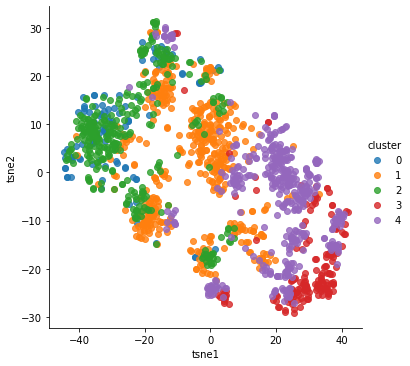

In [183]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_csv[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

# Number of entries that are null/void

In [184]:
train_csv.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
                   ..
PoolQC_qE           0
Fence_qE            0
MiscFeature_qE      0
SaleType_qE         0
SaleCondition_qE    0
Length: 124, dtype: int64

# Function to split training and validation data from the training set

In [9]:
def split_train_valid_data(data, perc=0.75):
    return data.head(int(len(data)*(perc)))
    


# Creation of the Dataloader

In [10]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_data, csv_file_test, id_col, target_col, data=None):
        self.data_train= pd.read_csv(csv_file_data)
        self.data_test = pd.read_csv(csv_file_test)
        self.id        = id_col
        self.target    = target_col
        self.data = data

    def __len__(self):
        if self.data == 'train':
            return len(self.data_train)
        else:
            return len(self.data_test)

    def __getitem__(self, idx):
        # remove the target column
        train_wo_SP = self.data_train.drop(self.target, axis='columns')
        # concat train and test features to have the same number of columns one the dummies features appear
        all_features = pd.concat([train_wo_SP, self.data_test], keys=["train", "test"])
        descri = all_features.describe()
        numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
        for feat in numeric_features:
            all_features[feat] = all_features[feat].fillna(descri[feat]['mean'])
        # Normalize the numerical features
        all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
        
        # creathe the dummies for train and test set
        all_features_dummies = pd.get_dummies(all_features)
        
        # creation of the label of train dataset
        train_label1 = self.data_train['Id']
        train_label2 = self.data_train['SalePrice']
        train_label = pd.DataFrame(columns = ['Id', 'SalePrice'])
        train_label['Id'] = train_label1
        train_label['SalePrice'] = train_label2
        
        #print(train_label)

        #Split Data - creation of the Validation dataset
        train_data = split_train_valid_data(all_features_dummies.loc['train'])
        valid_data = all_features_dummies.loc['train'].iloc[max(train_data.index+1):]

        
        #Split label - creation of the validation labelset
        label_train = split_train_valid_data(train_label)
        label_valid = train_label.iloc[max(train_data.index+1):]
         
        # creation of the test data set
        test_data = all_features_dummies.loc['test']
        
        # creation of an Empty label test
        label_test = pd.DataFrame(np.empty((test_data.shape[0],1)))
        
        train_data = train_data.astype(np.float32)
        valid_data = valid_data.astype(np.float32)
        test_data = test_data.astype(np.float32)
        label_train = label_train.astype(np.float32)
        label_valid = label_valid.astype(np.float32)
        
        # remove 'ID' columns - data
        train_data = train_data.drop(['Id'], axis=1)
        #print(len(train_data))
        valid_data = valid_data.drop(['Id'],axis=1)
        #print(len(valid_data))
        test_data = test_data.drop(['Id'], axis=1)
        #print(len(test_data))
        
        # remove 'ID' column - label
        label_train = label_train.drop(['Id'], axis=1)
        label_valid = label_valid.drop(['Id'], axis=1)
            
        # data preparation
        if self.data == 'train':
            use_data = train_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'valid':
            use_data = valid_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'test':
            use_data = test_data.to_numpy()
            use_data = torch.from_numpy(use_data)
            
        # label preparation
        if self.data == 'train':
            label_data = label_train.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'valid':
            label_data = label_valid.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'test':
            label_data = label_test.to_numpy()
            label_data = torch.from_numpy(label_data)
        
        return use_data, label_data

params = {
    'id_col':'Id',  
    'target_col': ['SalePrice'],
}

In [11]:
data_dataset = {x: CustomDataset(csv_file_data=data_dir+'train.csv', 
                                 csv_file_test=data_dir+'test.csv', 
                                 **params, 
                                 data='train' if x == 'train' 
                                 else 'valid' if x =='valid' 
                                 else 'test') 
                for x in ['train', 'valid', 'test']
               }


In [12]:
data_pg, lab_target_pg = data_dataset['test'].__getitem__(1)
print(data_pg)

tensor([[-0.8735,  0.5018,  0.1843,  ...,  0.0000,  1.0000,  0.0000],
        [-0.8735,  0.5487,  0.5197,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0673,  0.2203,  0.4643,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [-0.8735,  4.2555,  1.2466,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6553, -0.3428,  0.0346,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0673,  0.2203, -0.0686,  ...,  0.0000,  1.0000,  0.0000]])


In [13]:
data_loader = {x :torch.utils.data.DataLoader(data_dataset[x], batch_size=1, shuffle=True)
                for x in ['train', 'valid', 'test']}

In [14]:
print('TRAINING')

data, lab_target = data_dataset['train'].__getitem__(0)

print('DATASET')
print('Data shape: ', data.shape)
print('Data type: ', type(data))
print('Data size: {}'.format(data.size()))
#print('Exampe of the feature for the 1st entry {}'.format(data[0]))
print('\nTarget at the first row: {}'.format(lab_target.size()))
print('Example of the label for the 1st entry: {}'.format(lab_target[0]))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

datas, labels_target = train_iter.next()

print('DATALOADER')
print('images shape on batch size = ', datas.size())
print('Example of datas for the 1st entry {}'.format(datas[0].size()))
#print('\nTaregt type on batch size = {}'.format(labels_target))
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)
print(len(train_iter))

TRAINING
DATASET
Data shape:  torch.Size([1095, 288])
Data type:  <class 'torch.Tensor'>
Data size: torch.Size([1095, 288])

Target at the first row: torch.Size([1095, 1])
Example of the label for the 1st entry: tensor([208500.])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
DATALOADER
images shape on batch size =  torch.Size([1, 1095, 288])
Example of datas for the 1st entry torch.Size([1095, 288])
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([1, 1095, 1])
1460


# Model creation

In [15]:
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define linear layers
        
        # linear layer (330 -> 755001)
        self.fc1 = nn.Linear(288, 1)
        # linear layer (500 -> 250)
        #self.fc2 = nn.Linear(100, 50)
        # linear layer (250 -> 125)
        #self.fc3 = nn.Linear(50, 1)

        #self.dropout = nn.Dropout(0.1)
        
        # LogSoftmax
        self.RELU = nn.ReLU()
    
    def forward(self, x):
        
        #print('before l1 {}'.format(x))
        # 1LL
        x = self.RELU(self.fc1(x))
        #x = self.dropout(x)
        
        #print('before l2 {}'.format(x))
        # 2LL
        #x = torch.tanh(self.fc2(x))
        #x = self.dropout(x)
        
        #print('before l3 {}'.format(x))
        # 3LL
        #x = self.fc3(x)
        
        #print('After LR {}'.format(x))
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_HR = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_HR.cuda()

In [16]:
model_HR

Net(
  (fc1): Linear(in_features=288, out_features=1, bias=True)
  (RELU): ReLU()
)

In [17]:
next(model_HR.parameters()).is_cuda

False

# Torch Summary

In [18]:
summary(Net(),input_size=(1, 288))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            289
├─ReLU: 1-2                              --
Total params: 289
Trainable params: 289
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            289
├─ReLU: 1-2                              --
Total params: 289
Trainable params: 289
Non-trainable params: 0

In [28]:
#Learning rate
lr=0.01

#momentum
momentum = 0.8

### select loss function
criterion = nn.MSELoss()

# other Loss function
# 1-MSE
#criterion = nn.MSELoss()

# 2-Mae
def mae(true, pred):
    return np.sum(np.abs(true - pred))
# or
#criterion = nn.L1Loss()

# 3-huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

# 4-log cosh loss
def logcosh(true, pred):
    loss = np.log(np.cosh(pred - true))
    return np.sum(loss)

# 5-Quantile Loss / Note: the Quantile Loss is not define yet

### select optimizer


optimizer = optim.ASGD(model_HR.parameters(), lr=lr)

#other otpions: 
# SGD
# optim.SGD(model_HR.parameters(), lr=lr, momentum = momemtum)
# Sparse Adam - In this variant, only moments that show up in the gradient get updated, and only those portions of the gradient get applied to the parameters.
# optim.SparseAdam(model_HR.parameters(), lr=lr)
# Average Stochastic gradient descent
# optim.ASGD(model_HR.parameters(), lr=lr)
# RMSprop
# optim.RMSprop(model_HR.parameters(), lr=lr, momentum = momentum)



In [29]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            '''for name, param in model.named_parameters(): 
                if param.requires_grad: 
                    print(name, param.data)'''
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = criterion(output, target)           

        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = criterion(output, target)
        
        # Next todo, create a variable lr according to validation loss
        '''if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001'''
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            lr
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    # return trained model
    return model

Epoch: 1 	Training Loss: 563754560.000000 	Validation Loss: 1563424000.000000 	Time since the beginning 15.4 min 	Learning rate: 0.010000 
Validation loss decreased (inf --> 1563424000.000000).  Saving model ...
Epoch: 2 	Training Loss: 517497696.000000 	Validation Loss: 1552157440.000000 	Time since the beginning 29.8 min 	Learning rate: 0.010000 
Validation loss decreased (1563424000.000000 --> 1552157440.000000).  Saving model ...
Epoch: 3 	Training Loss: 495772960.000000 	Validation Loss: 1560775040.000000 	Time since the beginning 44.1 min 	Learning rate: 0.010000 
Epoch: 4 	Training Loss: 482823392.000000 	Validation Loss: 1572220288.000000 	Time since the beginning 58.5 min 	Learning rate: 0.010000 
Epoch: 5 	Training Loss: 474017056.000000 	Validation Loss: 1583784320.000000 	Time since the beginning 72.7 min 	Learning rate: 0.010000 


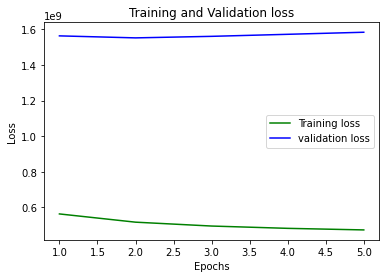

In [30]:
model_res = train(5, data_loader, model_HR, optimizer, criterion)

# Train with custon dataset

In [31]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            '''for name, param in model.named_parameters(): 
                if param.requires_grad: 
                    print(name, param.data)'''
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = criterion(output, target)           

        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = criterion(output, target)
        
        # Next todo, create a variable lr according to validation loss
        '''if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001'''
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            lr
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    # return trained model
    return model

In [32]:
model_res = train(10, data_dataset, model_HR, optimizer, criterion)

KeyboardInterrupt: 

# Result and submission file

In [33]:

print(len(data_loader['test']))
dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
datas, labels = dataiter_test.next()
print('images\n',datas.shape)
print('labels\n',labels.shape)

model_test = model_HR
model_test.load_state_dict(torch.load(VERSION))
model_test = model_test.eval()
print(model_test)

if use_cuda:
    datas = datas.cuda()
out_fwd = model_test.forward(datas)
print(out_fwd)
#print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
#probs = torch.exp(out_fwd)
#print('probs\n', probs)
#print(probs.max())
#print(probs.min())

1459
data_iter
images
 torch.Size([1, 1459, 288])
labels
 torch.Size([1, 1459, 1])
Net(
  (fc1): Linear(in_features=288, out_features=1, bias=True)
  (RELU): ReLU()
)
tensor([[[114769.9062],
         [163673.1406],
         [181656.6250],
         ...,
         [177801.9844],
         [119087.3750],
         [228039.9844]]], grad_fn=<ReluBackward0>)


In [34]:
for i in range(len(out_fwd)):
    submission.iloc[i][1] = out_fwd[i][0]

pd.set_option("display.max_rows", 10, "display.max_columns", None)

submission.to_csv(path_or_buf='sample_submission_'+VERSION+'.csv', index=False)

C:\Users\amallet\Anaconda3\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Score

result: - Ranking: 